In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = r'C:\Users\vatti\OneDrive\Documents\Data\mimic.db'
conn = sqlite3.connect(path)

In [3]:
# her all admissions for patients older than 65
admissions = pd.read_sql('select *, (julianday(date(admittime))-julianday(date(dob)))/365.25 as age from admissions, patients where admissions.subject_id = patients.subject_id and (julianday(date(admittime))-julianday(date(dob)))/365.25 >= 65',conn)

In [4]:
import time

In [5]:
# calculate los in hours
admissions['los_hrs']=admissions.apply(lambda r: (time.mktime(time.strptime(r['DISCHTIME'],'%Y-%m-%d %H:%M:%S')) - 
                 time.mktime(time.strptime(r['ADMITTIME'],'%Y-%m-%d %H:%M:%S')))/3600.0, axis=1)

In [6]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'ROW_ID', 'SUBJECT_ID',
       'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'age',
       'los_hrs'],
      dtype='object')

In [7]:
admissions[['los_hrs','HADM_ID','SUBJECT_ID']][:20]

,los_hrs,HADM_ID,SUBJECT_ID,SUBJECT_ID
0,330.233333,116935,249,249
1,254.983333,149546,249,249
2,407.950000,158975,249,249
3,115.283333,176189,253,253
4,72.000000,112013,255,255
5,171.733333,155415,256,256
6,157.116667,153771,256,256
7,301.183333,188869,256,256
8,148.083333,108811,256,256
9,68.250000,179006,257,257


#### 1. Model that uses first 24 hours of data and predicts mortality any time (after 24 hours) during hospitalization.

In [8]:
window_back = 24
window_forward = 0
shift = 1

In [9]:
window_size = window_back + window_forward
window_size

24

In [10]:
len((admissions[admissions['los_hrs'] < window_back]).index)

939

In [11]:
admissions.shape

(26044, 29)

In [12]:
len((admissions[admissions['los_hrs'] >= window_back]).index)

25105

In [13]:
pts = admissions.iloc[:,1].unique()

In [14]:
pts

array(['249', '253', '255', ..., '44082', '44089', '44123'], dtype=object)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
#split admissions by training and testing 
trp, tsp = train_test_split(pts, train_size=0.8)
tr = admissions[admissions.iloc[:,1].isin(trp)]
ts = admissions[admissions.iloc[:,1].isin(tsp)]

In [17]:
# select training data with more than minimul window size
tr_sel = tr[tr['los_hrs']>=window_back]

In [20]:
# not both input and output attributes

dts = []
for i in admissions.index[:100]:
  pt = admissions.iloc[i]  
  print('Patient:', pt.iloc[1])
  for t in range(window_back, int(pt['los_hrs'])):
    #print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str( t - window_back) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( t ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index) > 0:
        # output
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died on day of discharge
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
            # check if within the window
            and (time.mktime(time.strptime(pt['ADMITTIME'],'%Y-%m-%d %H:%M:%S')) + (t + window_forward) * 3600 >
                 time.mktime(time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')) )
           ):
            flag = 1
            #print('yes')
               
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        #print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        dts.append(d)
print('concatenating data')
dt = pd.concat(dts, ignore_index=True) 
del dts

Patient: 249
Patient: 249
Patient: 249
Patient: 253
Patient: 255
Patient: 256
Patient: 256
Patient: 256
Patient: 256
Patient: 257
Patient: 261
Patient: 266
Patient: 268
Patient: 270
Patient: 664
Patient: 665
Patient: 665
Patient: 667
Patient: 668
Patient: 670
Patient: 674
Patient: 674
Patient: 679
Patient: 679
Patient: 680
Patient: 682
Patient: 688
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 695
Patient: 695
Patient: 698
Patient: 698
Patient: 700
Patient: 703
Patient: 703
Patient: 704
Patient: 705
Patient: 707
Patient: 708
Patient: 709
Patient: 710
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 712
Patient: 716
Patient: 717
Patient: 718
Patient: 719
Patient: 723
Patient: 726
Patient: 727
Patient: 728
Patient: 728
Patient: 731
Patient: 731
Patient: 732
Patient: 733
Patient: 740
Patient: 743
Patient: 744
Patient: 746
Patient: 747
Patient: 747
Patient: 749
Patient: 752
Patient: 754
Patient: 755
Patient: 755
Patient: 756

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [21]:
class1 = dt[dt['class'] == 1]

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
cls = list(dt.columns)
cls.remove('class')
cls.remove('subject_id')
cls.remove('hadm_id')
cls.remove('t')

In [24]:
# need to imput missing values first
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
imp.fit(dt)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [25]:
st = pd.DataFrame(dt.columns)
st['stat'] = imp.statistics_

In [26]:
cols1 = list(st[st['stat'].notnull()][0])

In [27]:
dt1=pd.DataFrame(imp.transform(dt), columns=cols1)

In [28]:
cols1.remove('class')
cols1.remove('subject_id')
cols1.remove('hadm_id')
cols1.remove('t')

In [29]:
lr = LogisticRegression()
lr.fit(dt1[cols1],dt['class'])

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
probs = lr.predict_proba(dt1[cols1])[:,1]

In [31]:
probs

array([0.00192647, 0.00192647, 0.0020164 , ..., 0.00121878, 0.00121878,
       0.00121878])

In [32]:
dt1['probs'] = probs

In [33]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(dt1['class'], probs)

In [34]:
from matplotlib import pyplot as plt

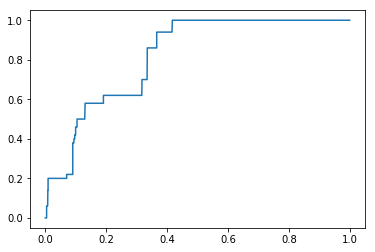

In [35]:
plt.plot(fpr,tpr)

In [36]:
auc(fpr,tpr)

0.819466602172288

#### 2. Model that uses 24-hour sliding window to predict morality at any time during hospitalization. 

In [37]:
window_back = 12
window_forward = 12
shift = 1

In [38]:
window_size = window_back + window_forward
window_size

24

In [39]:
pts = admissions.iloc[:,1].unique()

In [40]:
trp, tsp = train_test_split(pts, train_size=0.8)
tr = admissions[admissions.iloc[:,1].isin(trp)]
ts = admissions[admissions.iloc[:,1].isin(tsp)]

In [41]:
tr_sel = tr[tr['los_hrs']>=window_back]

In [42]:
dts = []
for i in admissions.index[:100]:
  pt = admissions.iloc[i]  
  print('Patient:', pt.iloc[1])
  for t in range(window_back, int(pt['los_hrs'])):
    #print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str( t - window_back) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( t ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index) > 0:
        # output
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died on day of discharge
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
            # check if within the window
            and (time.mktime(time.strptime(pt['ADMITTIME'],'%Y-%m-%d %H:%M:%S')) + (t + window_forward) * 3600 >
                 time.mktime(time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')) )
           ):
            flag = 1
            #print('yes')
               
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        #print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        dts.append(d)
print('concatenating data')
dt = pd.concat(dts, ignore_index=True) 
del dts

Patient: 249
Patient: 249
Patient: 249
Patient: 253
Patient: 255
Patient: 256
Patient: 256
Patient: 256
Patient: 256
Patient: 257
Patient: 261
Patient: 266
Patient: 268
Patient: 270
Patient: 664
Patient: 665
Patient: 665
Patient: 667
Patient: 668
Patient: 670
Patient: 674
Patient: 674
Patient: 679
Patient: 679
Patient: 680
Patient: 682
Patient: 688
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 690
Patient: 695
Patient: 695
Patient: 698
Patient: 698
Patient: 700
Patient: 703
Patient: 703
Patient: 704
Patient: 705
Patient: 707
Patient: 708
Patient: 709
Patient: 710
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 711
Patient: 712
Patient: 716
Patient: 717
Patient: 718
Patient: 719
Patient: 723
Patient: 726
Patient: 727
Patient: 728
Patient: 728
Patient: 731
Patient: 731
Patient: 732
Patient: 733
Patient: 740
Patient: 743
Patient: 744
Patient: 746
Patient: 747
Patient: 747
Patient: 749
Patient: 752
Patient: 754
Patient: 755
Patient: 755
Patient: 756

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [43]:
cls = list(dt.columns)
cls.remove('class')
cls.remove('subject_id')
cls.remove('hadm_id')
cls.remove('t')

In [44]:
imp.fit(dt)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [45]:
st = pd.DataFrame(dt.columns)
st['stat'] = imp.statistics_

In [46]:
cols1 = list(st[st['stat'].notnull()][0])

In [47]:
dt1=pd.DataFrame(imp.transform(dt), columns=cols1)

In [48]:
cols1.remove('class')
cols1.remove('subject_id')
cols1.remove('hadm_id')
cols1.remove('t')

In [49]:
lr = LogisticRegression()
lr.fit(dt1[cols1],dt['class'])

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
probs = lr.predict_proba(dt1[cols1])[:,1]

In [51]:
dt1['probs'] = probs

In [52]:
fpr, tpr, thresholds = roc_curve(dt1['class'], probs)

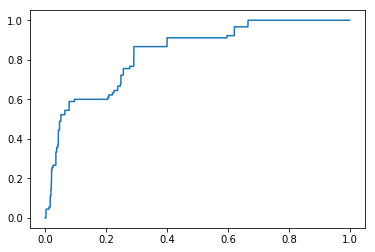

In [53]:
plt.plot(fpr,tpr)

In [54]:
auc(fpr,tpr)

0.8354645891500796

#### Dead Patients

In [56]:
dt1_sel = list(dt1[dt1['class'] == 1]['hadm_id'].unique())

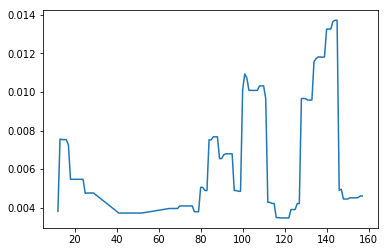

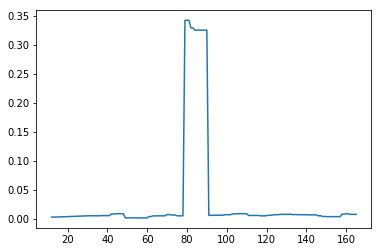

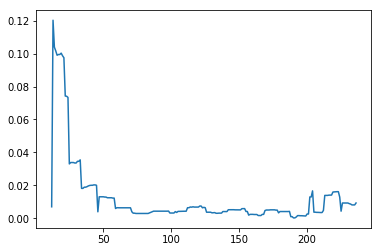

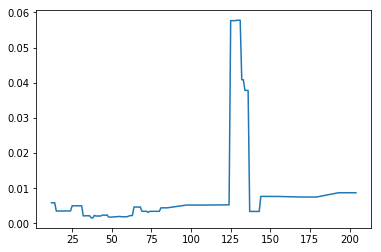

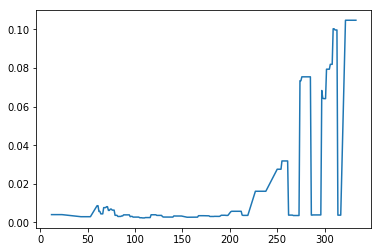

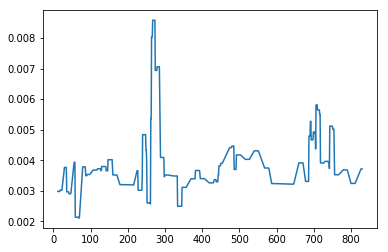

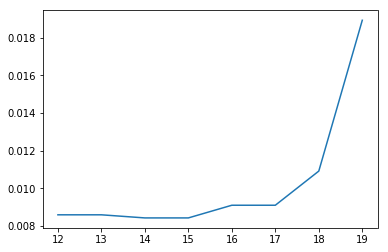

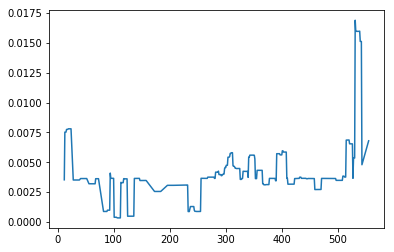

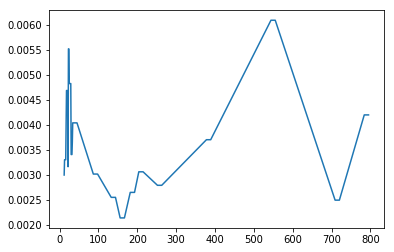

In [57]:
for a in dt1_sel:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

#### Alive Patients

In [60]:
dt1_sel = list(dt1[dt1['class'] == 0]['hadm_id'].unique())[:10]

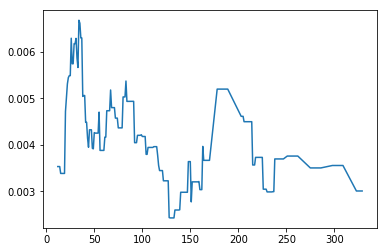

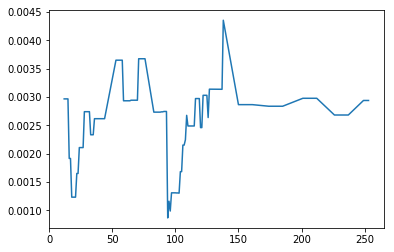

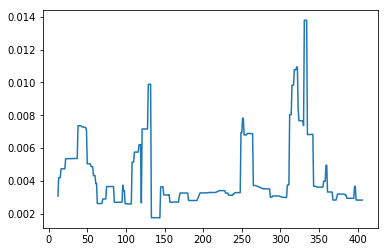

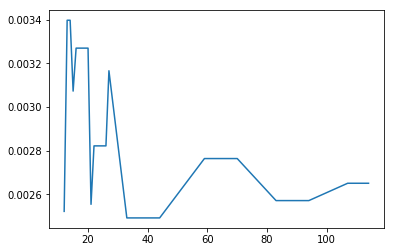

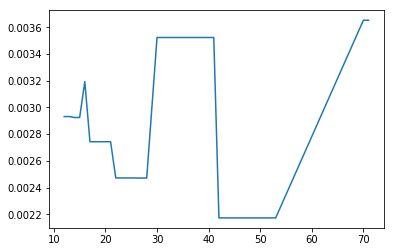

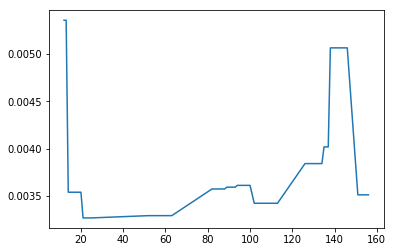

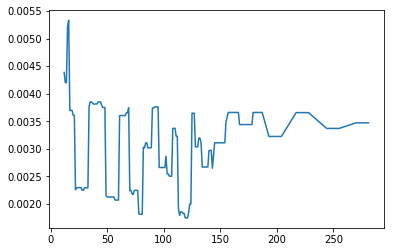

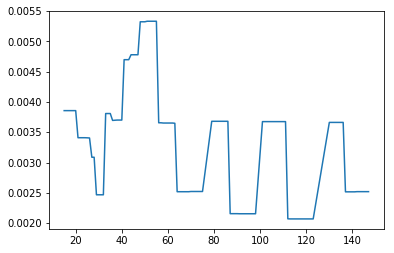

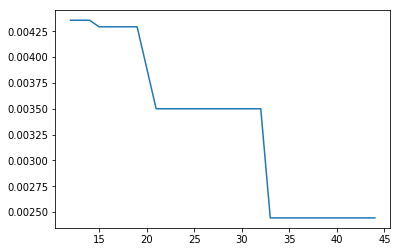

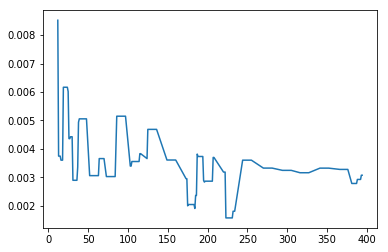

In [61]:
for a in dt1_sel:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

#### 3. Model that predicts mortality within 24 hours at any arbitrary point. 

In [62]:
window_back = 0
window_forward = 24
shift = 1

In [63]:
window_size = window_back + window_forward
window_size

24

In [64]:
pts = admissions.iloc[:,1].unique()

In [65]:
trp, tsp = train_test_split(pts, train_size=0.8)
tr = admissions[admissions.iloc[:,1].isin(trp)]
ts = admissions[admissions.iloc[:,1].isin(tsp)]

In [66]:
tr_sel = tr[tr['los_hrs']>=window_back]

In [85]:
dts = []
for i in tr_sel.index[:100]:
  pt = tr_sel.iloc[i]  
  print('Patient:', pt.iloc[1])
  for t in range(window_back, int(pt['los_hrs'])):
    print('Current time: ', t)
    labs = pd.read_sql("select * from labevents where hadm_id = \"" + pt[2] + 
                       "\" and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 >= " + str( t - window_back) +
                       " and (julianday(CHARTTIME) - julianday(\"" + pt[3] +
                       "\"))*24.0 < " + str( t ), conn)
    #print('   found labs: ',len(labs.index))
    if len(labs.index) > 0:
        # output
        flag = 0
        if ((pt['HOSPITAL_EXPIRE_FLAG'] == '1') 
            # check if died on day of discharge
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_year == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_year)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mon == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mon)
            and ((time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')).tm_mday == (time.strptime(pt['DISCHTIME'],'%Y-%m-%d %H:%M:%S')).tm_mday)
            # check if within the window
            and (time.mktime(time.strptime(pt['ADMITTIME'],'%Y-%m-%d %H:%M:%S')) + (t + window_forward) * 3600 >
                 time.mktime(time.strptime(pt['DOD_HOSP'],'%Y-%m-%d %H:%M:%S')) )
           ):
            flag = 1
            #print('yes')
               
        labs=labs.replace("",np.nan)
        labs['vn'] = labs.apply(lambda r: float(r['VALUENUM']),axis=1)
        gr = labs.groupby('ITEMID')
        print(pd.DataFrame(gr['vn'].mean()).T)
        d = pd.DataFrame(gr['vn'].mean()).T
        d['class'] = flag
        d['subject_id'] = pt.iloc[1]
        d['hadm_id'] = pt.iloc[2]
        d['t'] = t
        dts.append(d)
print('concatenating data')
dt = pd.concat(dts, ignore_index=True) 
del dts

Patient: 249
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current

Current time:  210
Current time:  211
Current time:  212
Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Current time:  239
Current time:  240
Current time:  241
Current time:  242
Current time:  243
Current time:  244
Current time:  245
Current time:  246
Current time:  247
Current time:  248
Current time:  249
Current time:  250
Current time:  251
Current time:  252
Current time:  253
Patient: 249
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  

Patient: 253
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current

Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current time:  55
Current time:  56
Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current ti

Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current time:  55
Current time:  56
Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current ti

Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current time:  55
Current time:  56
C

Current time:  187
Current time:  188
Current time:  189
Current time:  190
Current time:  191
Current time:  192
Current time:  193
Current time:  194
Current time:  195
Current time:  196
Current time:  197
Current time:  198
Current time:  199
Current time:  200
Current time:  201
Current time:  202
Current time:  203
Current time:  204
Current time:  205
Current time:  206
Current time:  207
Current time:  208
Current time:  209
Current time:  210
Current time:  211
Current time:  212
Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Current time

Current time:  153
Current time:  154
Current time:  155
Current time:  156
Current time:  157
Current time:  158
Current time:  159
Current time:  160
Current time:  161
Current time:  162
Current time:  163
Current time:  164
Current time:  165
Current time:  166
Current time:  167
Current time:  168
Current time:  169
Current time:  170
Current time:  171
Current time:  172
Current time:  173
Current time:  174
Current time:  175
Current time:  176
Current time:  177
Current time:  178
Current time:  179
Current time:  180
Current time:  181
Current time:  182
Current time:  183
Current time:  184
Current time:  185
Current time:  186
Current time:  187
Current time:  188
Current time:  189
Current time:  190
Current time:  191
Current time:  192
Current time:  193
Current time:  194
Current time:  195
Current time:  196
Current time:  197
Current time:  198
Current time:  199
Current time:  200
Current time:  201
Current time:  202
Current time:  203
Current time:  204
Current time

Current time:  653
Current time:  654
Current time:  655
Current time:  656
Current time:  657
Current time:  658
Current time:  659
Current time:  660
Current time:  661
Current time:  662
Current time:  663
Current time:  664
Current time:  665
Current time:  666
Current time:  667
Current time:  668
Current time:  669
Current time:  670
Current time:  671
Current time:  672
Current time:  673
Current time:  674
Current time:  675
Current time:  676
Current time:  677
Current time:  678
Current time:  679
Current time:  680
Current time:  681
Current time:  682
Current time:  683
Current time:  684
Current time:  685
Current time:  686
Current time:  687
Current time:  688
Current time:  689
Current time:  690
Current time:  691
Current time:  692
Current time:  693
Current time:  694
Current time:  695
Current time:  696
Current time:  697
Current time:  698
Current time:  699
Current time:  700
Current time:  701
Current time:  702
Current time:  703
Current time:  704
Current time

Current time:  1125
Current time:  1126
Current time:  1127
Current time:  1128
Current time:  1129
Current time:  1130
Current time:  1131
Current time:  1132
Current time:  1133
Current time:  1134
Current time:  1135
Current time:  1136
Current time:  1137
Current time:  1138
Current time:  1139
Current time:  1140
Current time:  1141
Current time:  1142
Current time:  1143
Current time:  1144
Current time:  1145
Current time:  1146
Current time:  1147
Current time:  1148
Current time:  1149
Current time:  1150
Current time:  1151
Current time:  1152
Current time:  1153
Current time:  1154
Current time:  1155
Current time:  1156
Current time:  1157
Current time:  1158
Current time:  1159
Current time:  1160
Current time:  1161
Current time:  1162
Current time:  1163
Current time:  1164
Current time:  1165
Current time:  1166
Current time:  1167
Current time:  1168
Current time:  1169
Current time:  1170
Current time:  1171
Current time:  1172
Current time:  1173
Current time:  1174


Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current time:  55
Current time:  56
Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current time:  78
Current time:  79
Current time:  80
Current time:  81
Current time:  82
Current time:  83
Current time:  84
Current time:  85
Current time:  86
Current time:  87
Current time:  88
Current time:  89
Current time:  90
Current ti

Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Current time:  239
Current time:  240
Current time:  241
Current time:  242
Current time:  243
Current time:  244
Current time:  245
Current time:  246
Current time:  247
Current time:  248
Current time:  249
Current time:  250
Current time:  251
Current time:  252
Current time:  253
Current time:  254
Current time:  255
Current time:  256
Current time:  257
Current time:  258
Current time:  259
Current time:  260
Current time:  261
Current time:  262
Current time:  263
Current time:  264
Current time:  265
Current time:  266
Current time:  267
Current time:  268
Current time:  269
Current time:  270
Current time:  271
Current time:  272
Current time:  273
Current time:  274
Current time:  275
Current time:  276
Current time:  277
Current time

Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Patient: 707
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current

Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Patient: 711
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46

Current time:  260
Current time:  261
Current time:  262
Current time:  263
Current time:  264
Current time:  265
Current time:  266
Current time:  267
Current time:  268
Current time:  269
Current time:  270
Current time:  271
Current time:  272
Current time:  273
Current time:  274
Current time:  275
Current time:  276
Current time:  277
Current time:  278
Current time:  279
Current time:  280
Current time:  281
Current time:  282
Current time:  283
Current time:  284
Current time:  285
Current time:  286
Current time:  287
Current time:  288
Current time:  289
Current time:  290
Current time:  291
Current time:  292
Current time:  293
Current time:  294
Current time:  295
Current time:  296
Current time:  297
Current time:  298
Current time:  299
Current time:  300
Current time:  301
Current time:  302
Current time:  303
Current time:  304
Current time:  305
Current time:  306
Current time:  307
Current time:  308
Current time:  309
Current time:  310
Current time:  311
Current time

Current time:  795
Current time:  796
Current time:  797
Current time:  798
Current time:  799
Current time:  800
Current time:  801
Current time:  802
Current time:  803
Current time:  804
Current time:  805
Current time:  806
Current time:  807
Current time:  808
Current time:  809
Current time:  810
Current time:  811
Current time:  812
Current time:  813
Current time:  814
Current time:  815
Current time:  816
Current time:  817
Current time:  818
Current time:  819
Current time:  820
Current time:  821
Current time:  822
Current time:  823
Current time:  824
Current time:  825
Current time:  826
Current time:  827
Current time:  828
Current time:  829
Current time:  830
Current time:  831
Current time:  832
Current time:  833
Current time:  834
Current time:  835
Current time:  836
Current time:  837
Current time:  838
Current time:  839
Current time:  840
Current time:  841
Current time:  842
Current time:  843
Current time:  844
Current time:  845
Current time:  846
Current time

Current time:  1250
Current time:  1251
Current time:  1252
Current time:  1253
Current time:  1254
Current time:  1255
Current time:  1256
Current time:  1257
Current time:  1258
Current time:  1259
Current time:  1260
Current time:  1261
Current time:  1262
Current time:  1263
Current time:  1264
Current time:  1265
Current time:  1266
Current time:  1267
Current time:  1268
Current time:  1269
Current time:  1270
Current time:  1271
Current time:  1272
Current time:  1273
Current time:  1274
Current time:  1275
Current time:  1276
Current time:  1277
Current time:  1278
Current time:  1279
Current time:  1280
Current time:  1281
Current time:  1282
Current time:  1283
Current time:  1284
Current time:  1285
Current time:  1286
Current time:  1287
Current time:  1288
Current time:  1289
Current time:  1290
Current time:  1291
Current time:  1292
Current time:  1293
Current time:  1294
Current time:  1295
Current time:  1296
Current time:  1297
Current time:  1298
Current time:  1299


Current time:  188
Current time:  189
Current time:  190
Current time:  191
Current time:  192
Current time:  193
Current time:  194
Current time:  195
Current time:  196
Current time:  197
Current time:  198
Current time:  199
Current time:  200
Current time:  201
Current time:  202
Current time:  203
Current time:  204
Current time:  205
Current time:  206
Current time:  207
Current time:  208
Current time:  209
Current time:  210
Current time:  211
Current time:  212
Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Current time:  239
Current time

Patient: 727
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current

Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current time:  55
Current time:  56
Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current time:  78
Current time:  79
Current time:  80
Current time:  81
Current time:  82
Current time:  83
Current time:  84
Current time:  85
Current time:  86
Current time:  87
Current time:  88
Current time:  89
Current time:  90
Current time:  91
Current time:  92
Current time:  93
Current time:  94
Current time:  95
Current time:  96
Current time:  97
Current time:  98
Current time:  99
Current time:  100
Current time:  101
Current time:  102
Current time:  103
Curren

Current time:  256
Current time:  257
Current time:  258
Current time:  259
Current time:  260
Current time:  261
Current time:  262
Current time:  263
Current time:  264
Current time:  265
Current time:  266
Current time:  267
Current time:  268
Current time:  269
Current time:  270
Current time:  271
Current time:  272
Current time:  273
Current time:  274
Current time:  275
Current time:  276
Current time:  277
Current time:  278
Current time:  279
Current time:  280
Current time:  281
Current time:  282
Current time:  283
Current time:  284
Current time:  285
Current time:  286
Current time:  287
Current time:  288
Current time:  289
Current time:  290
Current time:  291
Current time:  292
Current time:  293
Current time:  294
Current time:  295
Current time:  296
Current time:  297
Current time:  298
Current time:  299
Current time:  300
Current time:  301
Current time:  302
Current time:  303
Current time:  304
Current time:  305
Current time:  306
Current time:  307
Current time

Current time:  157
Current time:  158
Current time:  159
Current time:  160
Current time:  161
Current time:  162
Current time:  163
Current time:  164
Current time:  165
Current time:  166
Current time:  167
Current time:  168
Current time:  169
Current time:  170
Current time:  171
Current time:  172
Current time:  173
Current time:  174
Current time:  175
Current time:  176
Current time:  177
Current time:  178
Current time:  179
Current time:  180
Current time:  181
Current time:  182
Current time:  183
Current time:  184
Current time:  185
Current time:  186
Current time:  187
Current time:  188
Current time:  189
Current time:  190
Current time:  191
Current time:  192
Current time:  193
Current time:  194
Current time:  195
Current time:  196
Current time:  197
Current time:  198
Current time:  199
Current time:  200
Current time:  201
Current time:  202
Current time:  203
Current time:  204
Current time:  205
Current time:  206
Current time:  207
Current time:  208
Current time

Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current time:  55
Current time:  56
Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current ti

Current time:  515
Current time:  516
Current time:  517
Current time:  518
Current time:  519
Current time:  520
Current time:  521
Current time:  522
Current time:  523
Current time:  524
Current time:  525
Current time:  526
Current time:  527
Current time:  528
Current time:  529
Current time:  530
Current time:  531
Current time:  532
Current time:  533
Current time:  534
Current time:  535
Current time:  536
Current time:  537
Current time:  538
Current time:  539
Current time:  540
Current time:  541
Current time:  542
Current time:  543
Current time:  544
Current time:  545
Current time:  546
Current time:  547
Current time:  548
Current time:  549
Current time:  550
Current time:  551
Current time:  552
Current time:  553
Current time:  554
Current time:  555
Current time:  556
Current time:  557
Current time:  558
Current time:  559
Current time:  560
Current time:  561
Current time:  562
Current time:  563
Current time:  564
Current time:  565
Current time:  566
Current time

Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current time:  78
Current time:  79
Current time:  80
Current time:  81
Current time:  82
Current time:  83
Current time:  84
Current time:  85
Current time:  86
Current time:  87
Current time:  88
Current time:  89
Current time:  90
Current time:  91
Current time:  92
Current time:  93
Current time:  94
Current time:  95
Current time:  96
Current time:  97
Current time:  98
Current time:  99
Current time:  100
Current time:  101
Current time:  102
Current time:  103
Current time:  104
Current time:  105
Current time:  106
Current time:  107
Current time:  108
Current time:  109
Current time:  110
Current time:  111
Current time:  1

Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Current time:  239
Current time:  240
Current time:  241
Current time:  242
Current time:  243
Current time:  244
Current time:  245
Current time:  246
Current time:  247
Current time:  248
Current time:  249
Current time:  250
Current time:  251
Current time:  252
Current time:  253
Current time:  254
Current time:  255
Current time:  256
Current time:  257
Current time:  258
Current time:  259
Current time:  260
Current time:  261
Current time:  262
Current time:  263
Current time:  264
Current time:  265
Current time:  266
Current time

Current time:  302
Current time:  303
Current time:  304
Current time:  305
Current time:  306
Current time:  307
Current time:  308
Current time:  309
Current time:  310
Current time:  311
Current time:  312
Current time:  313
Current time:  314
Current time:  315
Current time:  316
Current time:  317
Current time:  318
Current time:  319
Current time:  320
Current time:  321
Current time:  322
Current time:  323
Current time:  324
Current time:  325
Current time:  326
Current time:  327
Current time:  328
Current time:  329
Current time:  330
Current time:  331
Current time:  332
Current time:  333
Current time:  334
Current time:  335
Current time:  336
Current time:  337
Current time:  338
Current time:  339
Current time:  340
Current time:  341
Current time:  342
Current time:  343
Current time:  344
Current time:  345
Current time:  346
Current time:  347
Current time:  348
Current time:  349
Current time:  350
Current time:  351
Current time:  352
Current time:  353
Current time

Current time:  799
Current time:  800
Current time:  801
Current time:  802
Current time:  803
Current time:  804
Current time:  805
Current time:  806
Current time:  807
Current time:  808
Current time:  809
Current time:  810
Current time:  811
Current time:  812
Current time:  813
Current time:  814
Current time:  815
Current time:  816
Current time:  817
Current time:  818
Current time:  819
Current time:  820
Current time:  821
Current time:  822
Current time:  823
Current time:  824
Current time:  825
Current time:  826
Current time:  827
Current time:  828
Current time:  829
Current time:  830
Current time:  831
Current time:  832
Current time:  833
Current time:  834
Current time:  835
Current time:  836
Current time:  837
Current time:  838
Current time:  839
Current time:  840
Current time:  841
Current time:  842
Current time:  843
Current time:  844
Current time:  845
Current time:  846
Current time:  847
Current time:  848
Current time:  849
Current time:  850
Current time

Current time:  1301
Current time:  1302
Current time:  1303
Current time:  1304
Current time:  1305
Current time:  1306
Current time:  1307
Current time:  1308
Current time:  1309
Current time:  1310
Current time:  1311
Current time:  1312
Current time:  1313
Current time:  1314
Current time:  1315
Current time:  1316
Current time:  1317
Current time:  1318
Current time:  1319
Current time:  1320
Current time:  1321
Current time:  1322
Current time:  1323
Current time:  1324
Current time:  1325
Current time:  1326
Current time:  1327
Current time:  1328
Current time:  1329
Current time:  1330
Current time:  1331
Current time:  1332
Current time:  1333
Current time:  1334
Current time:  1335
Current time:  1336
Patient: 755
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current

Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Current time:  239
Current time:  240
Current time:  241
Current time:  242
Current time:  243
Current time:  244
Current time:  245
Current time:  246
Current time:  247
Current time:  248
Current time:  249
Current time:  250
Current time:  251
Current time:  252
Current time:  253
Current time:  254
Current time:  255
Current time:  256
Current time:  257
Current time:  258
Current time:  259
Current time:  260
Current time:  261
Current time:  262
Current time:  263
Current time:  264
Current time:  265
Current time:  266
Current time:  267
Current time:  268
Current time:  269
Current time:  270
Current time

Current time:  190
Current time:  191
Current time:  192
Current time:  193
Current time:  194
Current time:  195
Current time:  196
Current time:  197
Current time:  198
Current time:  199
Current time:  200
Current time:  201
Current time:  202
Current time:  203
Current time:  204
Current time:  205
Current time:  206
Current time:  207
Current time:  208
Current time:  209
Current time:  210
Current time:  211
Current time:  212
Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Patient: 770
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:

Current time:  431
Current time:  432
Current time:  433
Current time:  434
Current time:  435
Current time:  436
Current time:  437
Current time:  438
Current time:  439
Current time:  440
Current time:  441
Current time:  442
Current time:  443
Current time:  444
Current time:  445
Current time:  446
Current time:  447
Current time:  448
Current time:  449
Current time:  450
Current time:  451
Current time:  452
Current time:  453
Current time:  454
Current time:  455
Current time:  456
Current time:  457
Current time:  458
Current time:  459
Current time:  460
Current time:  461
Current time:  462
Current time:  463
Current time:  464
Current time:  465
Current time:  466
Current time:  467
Current time:  468
Current time:  469
Current time:  470
Current time:  471
Current time:  472
Current time:  473
Current time:  474
Current time:  475
Current time:  476
Current time:  477
Current time:  478
Current time:  479
Current time:  480
Current time:  481
Current time:  482
Current time

Current time:  212
Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Current time:  239
Current time:  240
Current time:  241
Patient: 779
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:

Current time:  138
Current time:  139
Current time:  140
Current time:  141
Current time:  142
Current time:  143
Current time:  144
Current time:  145
Current time:  146
Current time:  147
Current time:  148
Current time:  149
Current time:  150
Current time:  151
Current time:  152
Current time:  153
Current time:  154
Current time:  155
Current time:  156
Current time:  157
Current time:  158
Current time:  159
Current time:  160
Current time:  161
Current time:  162
Current time:  163
Current time:  164
Current time:  165
Current time:  166
Current time:  167
Current time:  168
Current time:  169
Current time:  170
Current time:  171
Current time:  172
Current time:  173
Current time:  174
Current time:  175
Current time:  176
Current time:  177
Current time:  178
Current time:  179
Current time:  180
Current time:  181
Current time:  182
Current time:  183
Current time:  184
Current time:  185
Current time:  186
Current time:  187
Current time:  188
Current time:  189
Current time

Current time:  53
Current time:  54
Current time:  55
Current time:  56
Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current time:  78
Current time:  79
Current time:  80
Current time:  81
Current time:  82
Current time:  83
Current time:  84
Current time:  85
Current time:  86
Current time:  87
Current time:  88
Current time:  89
Current time:  90
Current time:  91
Current time:  92
Current time:  93
Current time:  94
Current time:  95
Current time:  96
Current time:  97
Current time:  98
Current time:  99
Current time:  100
Current time:  101
Current time:  102
Current time:  103
Current time:  104
Current time:  105
Current time:  106
Current time:  107
Cu

Current time:  371
Current time:  372
Current time:  373
Current time:  374
Current time:  375
Current time:  376
Current time:  377
Current time:  378
Current time:  379
Current time:  380
Current time:  381
Current time:  382
Current time:  383
Current time:  384
Current time:  385
Current time:  386
Current time:  387
Current time:  388
Current time:  389
Current time:  390
Current time:  391
Current time:  392
Current time:  393
Current time:  394
Current time:  395
Current time:  396
Current time:  397
Current time:  398
Current time:  399
Current time:  400
Current time:  401
Current time:  402
Current time:  403
Current time:  404
Current time:  405
Current time:  406
Current time:  407
Current time:  408
Current time:  409
Current time:  410
Current time:  411
Current time:  412
Current time:  413
Current time:  414
Current time:  415
Current time:  416
Current time:  417
Current time:  418
Current time:  419
Current time:  420
Current time:  421
Current time:  422
Current time

Current time:  841
Current time:  842
Current time:  843
Current time:  844
Current time:  845
Current time:  846
Current time:  847
Current time:  848
Current time:  849
Current time:  850
Current time:  851
Current time:  852
Current time:  853
Current time:  854
Current time:  855
Current time:  856
Current time:  857
Current time:  858
Current time:  859
Current time:  860
Current time:  861
Current time:  862
Current time:  863
Current time:  864
Current time:  865
Current time:  866
Current time:  867
Current time:  868
Current time:  869
Current time:  870
Current time:  871
Current time:  872
Current time:  873
Current time:  874
Current time:  875
Current time:  876
Current time:  877
Current time:  878
Current time:  879
Current time:  880
Current time:  881
Current time:  882
Current time:  883
Current time:  884
Current time:  885
Current time:  886
Current time:  887
Current time:  888
Current time:  889
Current time:  890
Current time:  891
Current time:  892
Current time

Current time:  1317
Current time:  1318
Current time:  1319
Current time:  1320
Current time:  1321
Current time:  1322
Current time:  1323
Current time:  1324
Current time:  1325
Current time:  1326
Current time:  1327
Current time:  1328
Current time:  1329
Current time:  1330
Current time:  1331
Current time:  1332
Current time:  1333
Current time:  1334
Current time:  1335
Current time:  1336
Current time:  1337
Current time:  1338
Current time:  1339
Current time:  1340
Current time:  1341
Current time:  1342
Current time:  1343
Current time:  1344
Current time:  1345
Current time:  1346
Current time:  1347
Current time:  1348
Current time:  1349
Current time:  1350
Current time:  1351
Current time:  1352
Current time:  1353
Current time:  1354
Current time:  1355
Current time:  1356
Current time:  1357
Current time:  1358
Current time:  1359
Current time:  1360
Current time:  1361
Current time:  1362
Current time:  1363
Current time:  1364
Current time:  1365
Current time:  1366


Current time:  179
Current time:  180
Current time:  181
Current time:  182
Current time:  183
Current time:  184
Current time:  185
Current time:  186
Current time:  187
Current time:  188
Current time:  189
Current time:  190
Current time:  191
Current time:  192
Current time:  193
Current time:  194
Current time:  195
Current time:  196
Current time:  197
Current time:  198
Current time:  199
Current time:  200
Current time:  201
Current time:  202
Current time:  203
Current time:  204
Current time:  205
Current time:  206
Current time:  207
Current time:  208
Current time:  209
Current time:  210
Current time:  211
Current time:  212
Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time

Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current time:  78
Current time:  79
Current time:  80
Current time:  81
Current time:  82
Current time:  83
Current time:  84
Current time:  85
Current time:  86
Current time:  87
Current time:  88
Current time:  89
Current time:  90
Current time:  91
Current time:  92
Current time:  93
Current time:  94
Current time:  95
Current time:  96
Current time:  97
Current time:  98
Current time:  99
Current time:  100
Current time:  101
Current time:  102
Current time:  103
Current time:  104
Current time:  105
Current time:  106
Current time:  107
Current time:  108
Current time:  109
Current time:  110
Current time:  111
Current time:  112
Current time:  

Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current time:  78
Current time:  79
Current time:  80
Current time:  81
Current time:  82
Current time:  83
Current time:  84
Current time:  85
Current time:  86
Current time:  87
Current time:  88
Current time:  89
Current time:  90
Current time:  91
Current time:  92
Current time:  93
Current time:  94
Current time:  95
Current time:  96
Current time:  97
Current time:  98
Current time:  99
Current time:  100
Current time:  101
Current time:  102
Current time:  103
Current time:  104
Current time:  105
Current time:  106
Current time:  107
Current time:  108
Current time:  109
Current time:  110
Current time:  111
Current time:  112
Current time:  113
Current time:  114
Current time:  115
Current time:  116
Current time:  117
Current ti

Current time:  172
Current time:  173
Current time:  174
Current time:  175
Current time:  176
Current time:  177
Current time:  178
Current time:  179
Current time:  180
Current time:  181
Current time:  182
Current time:  183
Current time:  184
Current time:  185
Current time:  186
Current time:  187
Current time:  188
Current time:  189
Current time:  190
Current time:  191
Current time:  192
Current time:  193
Current time:  194
Current time:  195
Current time:  196
Current time:  197
Current time:  198
Current time:  199
Current time:  200
Current time:  201
Current time:  202
Current time:  203
Current time:  204
Current time:  205
Current time:  206
Current time:  207
Current time:  208
Current time:  209
Current time:  210
Current time:  211
Current time:  212
Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time

Current time:  653
Current time:  654
Current time:  655
Current time:  656
Current time:  657
Current time:  658
Current time:  659
Current time:  660
Current time:  661
Current time:  662
Current time:  663
Current time:  664
Current time:  665
Current time:  666
Current time:  667
Current time:  668
Current time:  669
Current time:  670
Current time:  671
Current time:  672
Current time:  673
Current time:  674
Current time:  675
Current time:  676
Current time:  677
Current time:  678
Current time:  679
Current time:  680
Current time:  681
Current time:  682
Current time:  683
Current time:  684
Current time:  685
Current time:  686
Current time:  687
Current time:  688
Current time:  689
Current time:  690
Current time:  691
Current time:  692
Current time:  693
Current time:  694
Current time:  695
Current time:  696
Current time:  697
Current time:  698
Current time:  699
Current time:  700
Current time:  701
Current time:  702
Current time:  703
Current time:  704
Current time

Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Current time:  55
Current time:  56
Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current ti

Current time:  123
Current time:  124
Current time:  125
Current time:  126
Current time:  127
Current time:  128
Current time:  129
Current time:  130
Current time:  131
Current time:  132
Current time:  133
Current time:  134
Current time:  135
Current time:  136
Current time:  137
Current time:  138
Current time:  139
Current time:  140
Current time:  141
Current time:  142
Current time:  143
Current time:  144
Current time:  145
Current time:  146
Current time:  147
Current time:  148
Current time:  149
Current time:  150
Current time:  151
Current time:  152
Current time:  153
Current time:  154
Current time:  155
Current time:  156
Current time:  157
Current time:  158
Current time:  159
Current time:  160
Current time:  161
Current time:  162
Current time:  163
Current time:  164
Current time:  165
Current time:  166
Current time:  167
Current time:  168
Current time:  169
Current time:  170
Current time:  171
Current time:  172
Current time:  173
Current time:  174
Current time

Current time:  110
Current time:  111
Current time:  112
Current time:  113
Current time:  114
Current time:  115
Current time:  116
Current time:  117
Current time:  118
Current time:  119
Current time:  120
Current time:  121
Current time:  122
Current time:  123
Current time:  124
Current time:  125
Current time:  126
Current time:  127
Current time:  128
Current time:  129
Current time:  130
Current time:  131
Current time:  132
Current time:  133
Current time:  134
Current time:  135
Current time:  136
Current time:  137
Current time:  138
Current time:  139
Current time:  140
Current time:  141
Current time:  142
Current time:  143
Current time:  144
Current time:  145
Current time:  146
Current time:  147
Current time:  148
Current time:  149
Current time:  150
Current time:  151
Current time:  152
Current time:  153
Current time:  154
Current time:  155
Current time:  156
Current time:  157
Current time:  158
Current time:  159
Current time:  160
Current time:  161
Current time

Current time:  121
Current time:  122
Current time:  123
Current time:  124
Current time:  125
Current time:  126
Current time:  127
Current time:  128
Current time:  129
Current time:  130
Current time:  131
Current time:  132
Current time:  133
Current time:  134
Current time:  135
Current time:  136
Current time:  137
Current time:  138
Current time:  139
Current time:  140
Current time:  141
Current time:  142
Current time:  143
Current time:  144
Current time:  145
Current time:  146
Current time:  147
Current time:  148
Current time:  149
Current time:  150
Current time:  151
Current time:  152
Current time:  153
Current time:  154
Current time:  155
Current time:  156
Current time:  157
Current time:  158
Current time:  159
Current time:  160
Current time:  161
Current time:  162
Current time:  163
Current time:  164
Current time:  165
Current time:  166
Current time:  167
Current time:  168
Current time:  169
Current time:  170
Current time:  171
Current time:  172
Current time

Current time:  178
Current time:  179
Current time:  180
Current time:  181
Current time:  182
Current time:  183
Current time:  184
Current time:  185
Current time:  186
Current time:  187
Current time:  188
Current time:  189
Current time:  190
Current time:  191
Current time:  192
Current time:  193
Current time:  194
Current time:  195
Current time:  196
Current time:  197
Current time:  198
Current time:  199
Current time:  200
Current time:  201
Current time:  202
Current time:  203
Current time:  204
Current time:  205
Current time:  206
Current time:  207
Current time:  208
Current time:  209
Current time:  210
Current time:  211
Current time:  212
Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time

Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  44
Current time:  45
Current time:  46
Current time:  47
Current time:  48
Current time:  49
Current time:  50
Current time:  51
Current time:  52
Current time:  53
Current time:  54
Patient: 832
Current time:  0
Current time:  1
Current

Current time:  317
Current time:  318
Current time:  319
Current time:  320
Current time:  321
Current time:  322
Current time:  323
Current time:  324
Current time:  325
Current time:  326
Current time:  327
Current time:  328
Current time:  329
Current time:  330
Current time:  331
Current time:  332
Current time:  333
Current time:  334
Current time:  335
Current time:  336
Current time:  337
Current time:  338
Current time:  339
Current time:  340
Current time:  341
Current time:  342
Current time:  343
Current time:  344
Current time:  345
Current time:  346
Current time:  347
Current time:  348
Current time:  349
Current time:  350
Current time:  351
Current time:  352
Current time:  353
Current time:  354
Current time:  355
Current time:  356
Current time:  357
Current time:  358
Current time:  359
Current time:  360
Current time:  361
Current time:  362
Current time:  363
Current time:  364
Current time:  365
Current time:  366
Current time:  367
Current time:  368
Current time

Current time:  820
Current time:  821
Current time:  822
Current time:  823
Current time:  824
Current time:  825
Current time:  826
Current time:  827
Current time:  828
Current time:  829
Current time:  830
Current time:  831
Current time:  832
Current time:  833
Current time:  834
Current time:  835
Current time:  836
Current time:  837
Current time:  838
Current time:  839
Current time:  840
Current time:  841
Current time:  842
Current time:  843
Current time:  844
Current time:  845
Current time:  846
Current time:  847
Current time:  848
Current time:  849
Current time:  850
Current time:  851
Current time:  852
Current time:  853
Current time:  854
Current time:  855
Current time:  856
Current time:  857
Current time:  858
Current time:  859
Current time:  860
Current time:  861
Current time:  862
Current time:  863
Current time:  864
Current time:  865
Current time:  866
Current time:  867
Current time:  868
Current time:  869
Current time:  870
Current time:  871
Current time

Current time:  1276
Current time:  1277
Current time:  1278
Current time:  1279
Current time:  1280
Current time:  1281
Current time:  1282
Current time:  1283
Current time:  1284
Current time:  1285
Current time:  1286
Current time:  1287
Current time:  1288
Current time:  1289
Current time:  1290
Current time:  1291
Current time:  1292
Current time:  1293
Current time:  1294
Current time:  1295
Current time:  1296
Current time:  1297
Current time:  1298
Current time:  1299
Current time:  1300
Current time:  1301
Current time:  1302
Current time:  1303
Current time:  1304
Current time:  1305
Current time:  1306
Current time:  1307
Current time:  1308
Current time:  1309
Current time:  1310
Current time:  1311
Current time:  1312
Current time:  1313
Current time:  1314
Current time:  1315
Current time:  1316
Current time:  1317
Current time:  1318
Current time:  1319
Current time:  1320
Current time:  1321
Current time:  1322
Current time:  1323
Current time:  1324
Current time:  1325


Current time:  1759
Current time:  1760
Current time:  1761
Current time:  1762
Current time:  1763
Current time:  1764
Current time:  1765
Current time:  1766
Current time:  1767
Current time:  1768
Current time:  1769
Current time:  1770
Current time:  1771
Current time:  1772
Current time:  1773
Current time:  1774
Current time:  1775
Current time:  1776
Current time:  1777
Current time:  1778
Current time:  1779
Current time:  1780
Current time:  1781
Current time:  1782
Current time:  1783
Current time:  1784
Current time:  1785
Current time:  1786
Current time:  1787
Current time:  1788
Current time:  1789
Current time:  1790
Current time:  1791
Current time:  1792
Current time:  1793
Current time:  1794
Current time:  1795
Current time:  1796
Current time:  1797
Current time:  1798
Current time:  1799
Current time:  1800
Current time:  1801
Current time:  1802
Current time:  1803
Current time:  1804
Current time:  1805
Current time:  1806
Current time:  1807
Current time:  1808


Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current time:  78
Current time:  79
Current time:  80
Current time:  81
Current time:  82
Current time:  83
Current time:  84
Current time:  85
Current time:  86
Current time:  87
Current time:  88
Current time:  89
Current time:  90
Current time:  91
Current time:  92
Current time:  93
Current time:  94
Current time:  95
Current time:  96
Current time:  97
Current time:  98
Current time:  99
Current time:  100
Current time:  101
Current time:  102
Current time:  103
Current time:  104
Current time:  105
Current time:  106
Current time:  107
Current time:  108
Current time:  109
Current time:  110
Current time:  11

Current time:  498
Current time:  499
Current time:  500
Current time:  501
Current time:  502
Current time:  503
Current time:  504
Current time:  505
Current time:  506
Current time:  507
Current time:  508
Current time:  509
Current time:  510
Current time:  511
Current time:  512
Current time:  513
Current time:  514
Current time:  515
Current time:  516
Current time:  517
Current time:  518
Current time:  519
Current time:  520
Current time:  521
Current time:  522
Current time:  523
Current time:  524
Current time:  525
Current time:  526
Current time:  527
Current time:  528
Current time:  529
Current time:  530
Current time:  531
Current time:  532
Current time:  533
Current time:  534
Current time:  535
Current time:  536
Current time:  537
Current time:  538
Current time:  539
Current time:  540
Current time:  541
Current time:  542
Current time:  543
Current time:  544
Current time:  545
Current time:  546
Current time:  547
Current time:  548
Current time:  549
Current time

Current time:  118
Current time:  119
Current time:  120
Current time:  121
Current time:  122
Current time:  123
Current time:  124
Current time:  125
Current time:  126
Current time:  127
Patient: 854
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27
Current time:  28
Current time:  29
Current time:  30
Current time:  31
Current time:  32
Current time:  33
Current time:  34
Current time:  35
Current time:  36
Current time:  37
Current time:  38
Current time:  39
Current time:  40
Current time:  41
Current time:  42
Current time:  43
Current time:  

Current time:  52
Current time:  53
Current time:  54
Current time:  55
Current time:  56
Current time:  57
Current time:  58
Current time:  59
Current time:  60
Current time:  61
Current time:  62
Current time:  63
Current time:  64
Current time:  65
Current time:  66
Current time:  67
Current time:  68
Current time:  69
Current time:  70
Current time:  71
Current time:  72
Current time:  73
Current time:  74
Current time:  75
Current time:  76
Current time:  77
Current time:  78
Current time:  79
Current time:  80
Current time:  81
Current time:  82
Current time:  83
Current time:  84
Current time:  85
Current time:  86
Current time:  87
Current time:  88
Current time:  89
Current time:  90
Current time:  91
Current time:  92
Current time:  93
Current time:  94
Current time:  95
Current time:  96
Current time:  97
Current time:  98
Current time:  99
Current time:  100
Current time:  101
Current time:  102
Current time:  103
Current time:  104
Current time:  105
Current time:  106
Cur

Current time:  213
Current time:  214
Current time:  215
Current time:  216
Current time:  217
Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Patient: 657
Current time:  0
Current time:  1
Current time:  2
Current time:  3
Current time:  4
Current time:  5
Current time:  6
Current time:  7
Current time:  8
Current time:  9
Current time:  10
Current time:  11
Current time:  12
Current time:  13
Current time:  14
Current time:  15
Current time:  16
Current time:  17
Current time:  18
Current time:  19
Current time:  20
Current time:  21
Current time:  22
Current time:  23
Current time:  24
Current time:  25
Current time:  26
Current time:  27

Current time:  129
Current time:  130
Current time:  131
Current time:  132
Current time:  133
Current time:  134
Current time:  135
Current time:  136
Current time:  137
Current time:  138
Current time:  139
Current time:  140
Current time:  141
Current time:  142
Current time:  143
Current time:  144
Current time:  145
Current time:  146
Current time:  147
Current time:  148
Current time:  149
Current time:  150
Current time:  151
Current time:  152
Current time:  153
Current time:  154
Current time:  155
Current time:  156
Current time:  157
Current time:  158
Current time:  159
Current time:  160
Current time:  161
Current time:  162
Current time:  163
Current time:  164
Current time:  165
Current time:  166
Current time:  167
Current time:  168
Current time:  169
Current time:  170
Current time:  171
Current time:  172
Current time:  173
Current time:  174
Current time:  175
Current time:  176
Current time:  177
Current time:  178
Current time:  179
Current time:  180
Current time

Current time:  218
Current time:  219
Current time:  220
Current time:  221
Current time:  222
Current time:  223
Current time:  224
Current time:  225
Current time:  226
Current time:  227
Current time:  228
Current time:  229
Current time:  230
Current time:  231
Current time:  232
Current time:  233
Current time:  234
Current time:  235
Current time:  236
Current time:  237
Current time:  238
Current time:  239
Current time:  240
Current time:  241
Current time:  242
Current time:  243
Current time:  244
Current time:  245
Current time:  246
Current time:  247
Current time:  248
Current time:  249
Current time:  250
Current time:  251
Current time:  252
Current time:  253
Current time:  254
Current time:  255
Current time:  256
Current time:  257
Current time:  258
Current time:  259
Current time:  260
Current time:  261
Current time:  262
Current time:  263
Current time:  264
Current time:  265
Current time:  266
Current time:  267
Current time:  268
Current time:  269
Current time

Current time:  262
Current time:  263
Current time:  264
Current time:  265
Current time:  266
Current time:  267
Current time:  268
Current time:  269
Current time:  270
Current time:  271
Current time:  272
Current time:  273
Current time:  274
Current time:  275
Current time:  276
Current time:  277
Current time:  278
Current time:  279
Current time:  280
Current time:  281
Current time:  282
Current time:  283
Current time:  284
Current time:  285
Current time:  286
Current time:  287
Current time:  288
Current time:  289
Current time:  290
Current time:  291
Current time:  292
Current time:  293
Current time:  294
Current time:  295
Current time:  296
Current time:  297
Current time:  298
Current time:  299
Current time:  300
Current time:  301
Current time:  302
Current time:  303
Current time:  304
Current time:  305
Current time:  306
Current time:  307
Current time:  308
Current time:  309
Current time:  310
Current time:  311
Current time:  312
Current time:  313
Current time

Current time:  120
Current time:  121
Current time:  122
Current time:  123
Current time:  124
Current time:  125
Current time:  126
Current time:  127
concatenating data


In [86]:
cls = list(dt.columns)
cls.remove('class')
cls.remove('subject_id')
cls.remove('hadm_id')
cls.remove('t')

In [87]:
imp.fit(dt)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [88]:
st = pd.DataFrame(dt.columns)
st['stat'] = imp.statistics_

In [89]:
cols1 = list(st[st['stat'].notnull()][0])

In [90]:
dt1=pd.DataFrame(imp.transform(dt), columns=cols1)

In [91]:
cols1.remove('class')
cols1.remove('subject_id')
cols1.remove('hadm_id')
cols1.remove('t')

In [92]:
lr.fit(dt1[cols1],dt['class'])

c:\users\vatti\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
probs = lr.predict_proba(dt1[cols1])[:,1]

In [94]:
dt1['probs'] = probs

In [95]:
fpr, tpr, thresholds = roc_curve(dt1['class'], probs)

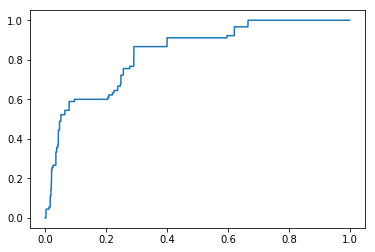

In [96]:
plt.plot(fpr,tpr)

In [97]:
auc(fpr,tpr)

0.8354645891500796

#### Dead Patients

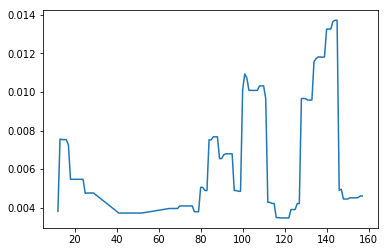

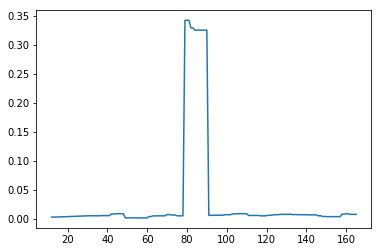

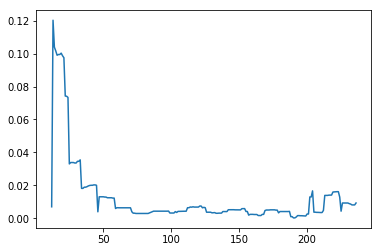

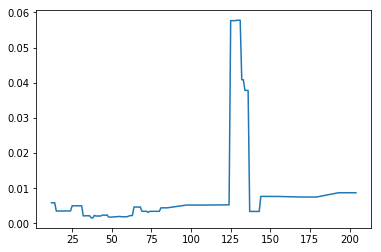

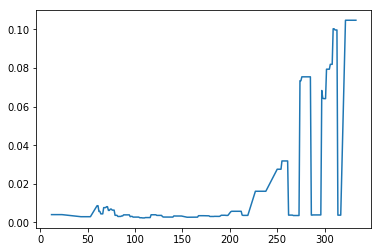

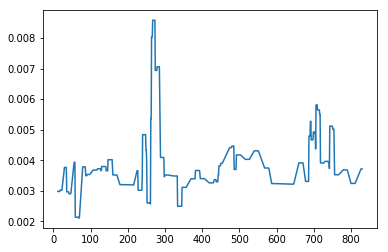

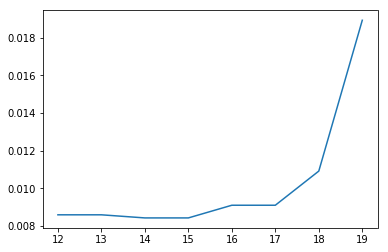

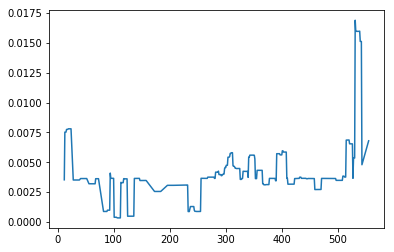

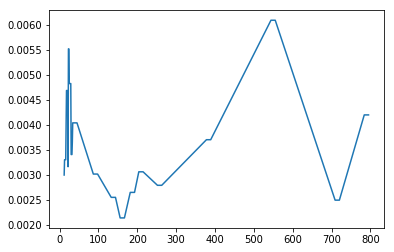

In [98]:
dt1_sel = list(dt1[dt1['class'] == 1]['hadm_id'].unique())

for a in dt1_sel:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()

#### Alive Patients

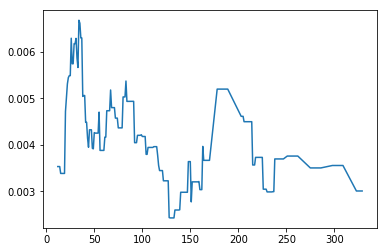

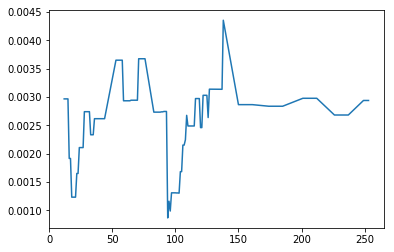

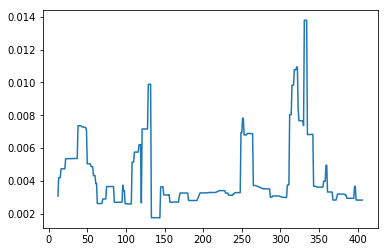

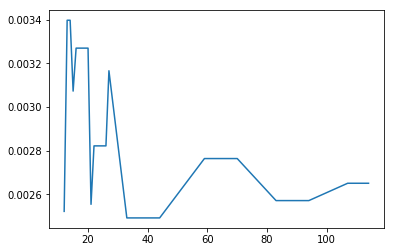

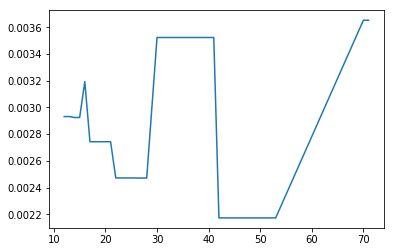

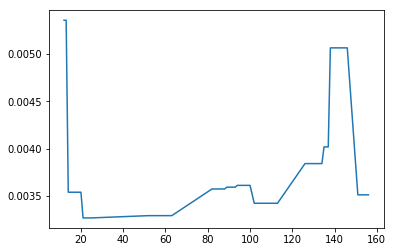

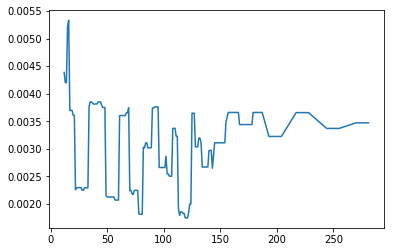

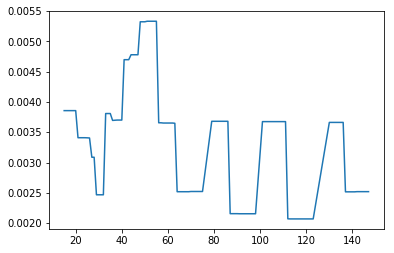

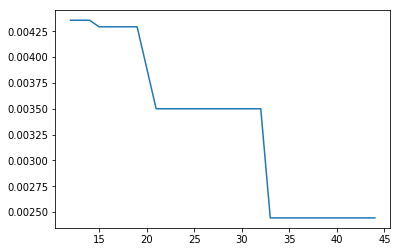

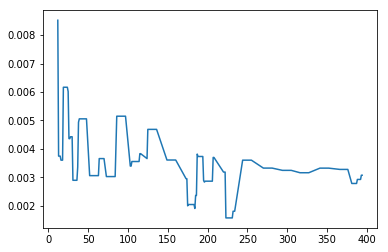

In [99]:
dt1_sel = list(dt1[dt1['class'] == 0]['hadm_id'].unique())[:10]

for a in dt1_sel:
    dt1_sel = dt1[dt1['hadm_id'] == a]
    plt.plot(dt1_sel['t'],dt1_sel['probs'])
    plt.show()